<a href="https://colab.research.google.com/github/Saha-Manav/Lung-Cancer-Classification-Research-/blob/main/LC_DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive to access dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K


In [ ]:
# Define constants and paths
train_dir = '/content/drive/MyDrive/Lung Cancer ML Project/LIDC dataset/train'
val_dir = '/content/drive/MyDrive/Lung Cancer ML Project/LIDC dataset/validation'
test_dir = '/content/drive/MyDrive/Lung Cancer ML Project/LIDC dataset/test'

batch_size = 16
img_height = 128
img_width = 128
num_classes = 2

In [ ]:
# Data augmentation and rescaling for training data (Uncommented and added transformations) +
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_test_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 5197 images belonging to 2 classes.
Found 1297 images belonging to 2 classes.
Found 1622 images belonging to 2 classes.


In [ ]:
# Compute class weights for imbalanced dataset
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert class weights to a dictionary
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)

Class Weights: {0: 0.5984569322892677, 1: 3.0391812865497077}


In [ ]:
# Load DenseNet121 model with pre-trained weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze most of the layers and make the top few layers trainable
for layer in base_model.layers[-50:]:  # Unfreeze the top 50 layers
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Set up callbacks (increased patience for early stopping)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Train the model with increased epochs (20)
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size,
    epochs=20,  # Increased epochs to 20
    class_weight=class_weights,  # Using class weights
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.6465 - loss: 0.6834 
Epoch 1: val_loss improved from inf to 0.26224, saving model to best_model.keras
324/324 ━━━━━━━━━━━━━━━━━━━━ 5111s 15s/step - accuracy: 0.6468 - loss: 0.6830 - val_accuracy: 0.9043 - val_loss: 0.2622
Epoch 2/20
  1/324 ━━━━━━━━━━━━━━━━━━━━ 31s 98ms/step - accuracy: 0.8750 - loss: 0.5494

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.26224 to 0.15915, saving model to best_model.keras
324/324 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.8750 - loss: 0.5494 - val_accuracy: 1.0000 - val_loss: 0.1591
Epoch 3/20
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.8608 - loss: 0.3263
Epoch 3: val_loss did not improve from 0.15915
324/324 ━━━━━━━━━━━━━━━━━━━━ 51s 154ms/step - accuracy: 0.8609 - loss: 0.3262 - val_accuracy: 0.8580 - val_loss: 0.3264
Epoch 4/20
  1/324 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.9375 - loss: 0.1700
Epoch 4: val_loss did not improve from 0.15915
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 149us/step - accuracy: 0.9375 - loss: 0.1700 - val_accuracy: 1.0000 - val_loss: 0.1898
Epoch 5/20
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8977 - loss: 0.2407
Epoch 5: val_loss did not improve from 0.15915
324/324 ━━━━━━━━━━━━━━━━━━━━ 52s 157ms/step - accuracy: 0.8977 - loss: 0.2407 - val_accuracy: 0.9167 - val_loss: 0.2174
Epoch 6/20
  1/324 ━━━━━━━━━━━━━

In [ ]:

# Define Focal Loss function
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        loss = alpha * K.pow(1. - y_pred, gamma) * cross_entropy
        return K.sum(loss, axis=-1)
    return focal_loss_fixed

# Compile model using Focal Loss instead of categorical cross-entropy
model.compile(optimizer=Adam(learning_rate=1e-5), loss=focal_loss(), metrics=['accuracy'])


In [ ]:
# Load the best model
model.load_weights('best_model.keras')

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test accuracy: {test_acc:.4f}')


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 654 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


101/101 ━━━━━━━━━━━━━━━━━━━━ 1465s 15s/step - accuracy: 0.9837 - loss: 0.0065
Test accuracy: 0.9610


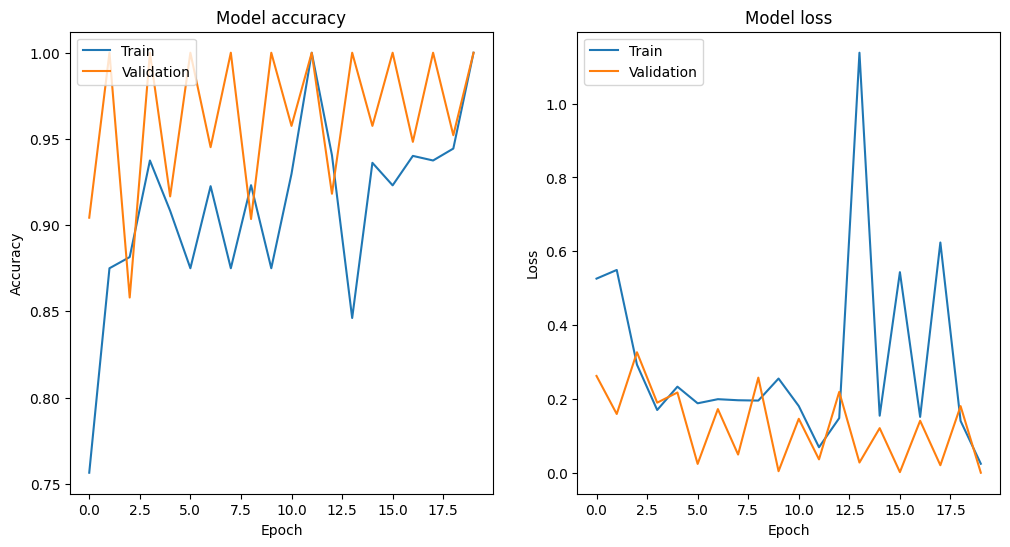

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


102/102 ━━━━━━━━━━━━━━━━━━━━ 24s 160ms/step


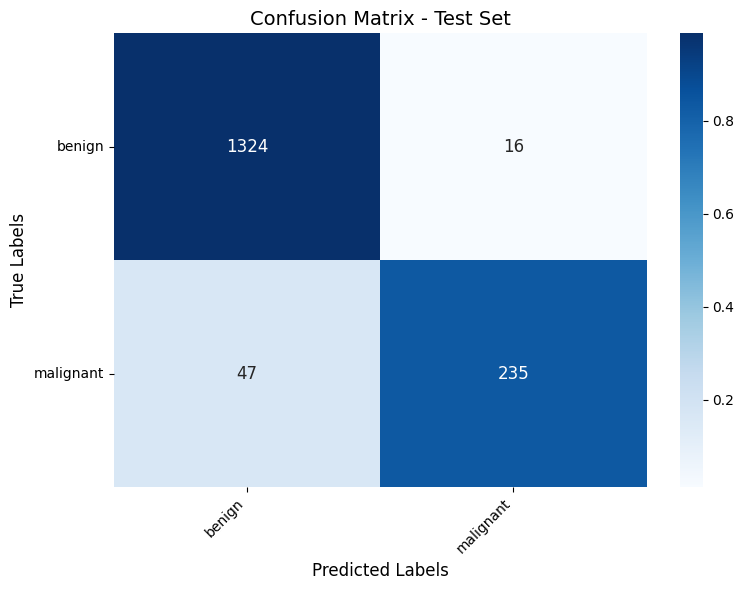

Classification Report
              precision    recall  f1-score   support

      benign       0.97      0.99      0.98      1340
   malignant       0.94      0.83      0.88       282

    accuracy                           0.96      1622
   macro avg       0.95      0.91      0.93      1622
weighted avg       0.96      0.96      0.96      1622



In [ ]:
# Predictions and metrics
test_predictions = model.predict(test_generator)
test_true = test_generator.classes
test_pred_labels = np.argmax(test_predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_true, test_pred_labels)

# Normalize confusion matrix for better visual comparison
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(8, 6))

# Annotate with actual numbers (confusion matrix values)
sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', cbar=True, annot_kws={"size": 12})

# Add labels and title
plt.title('Confusion Matrix - Test Set', fontsize=14)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

# Add tick marks for class labels
class_names = list(test_generator.class_indices.keys())  # Replace with actual class names if needed
plt.xticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=45, ha="right", fontsize=10)
plt.yticks(ticks=np.arange(len(class_names)) + 0.5, labels=class_names, rotation=0, fontsize=10)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

# Print the classification report
print('Classification Report')
print(classification_report(test_true, test_pred_labels, target_names=class_names))



In [ ]:
# Save the model
model.save('densenet121_lung_cancer.keras')
